# PRS map - summary plots

Yosuke Tanigawa


## library, functions, and constants

In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(tidyverse)
    library(data.table)
}))


In [2]:
source('0_parameters.sh')


In [3]:
devtools::load_all('/oak/stanford/groups/mrivas/users/ytanigaw/repos/yk-tanigawa/cud4')


Loading cud4



In [4]:
#' Transform the evaluation metric data frame to 
#' the multi-ethnic transferability metric against WB test set
#'
#' @param eval_df a data frae containing the predictive performance metric. 
#' Each row has the predictive performance of phenotype for a given pair of trait and ethnic group
#' We assume the table has 'trait' and 'split' columns
#' @param metric_col a string specifying the column name that contains the predictive performance measure
#' @param trans_ethnic_eval_func a function that takes two arguments 
#' (a metric in non-WB pop and the correspondig metric in WB test set) and returns a transferability measure
#' example: function(x, x_WB){ x - x_WB }
#' @return a new data frame containing three columns: trait, split, <metric_col>_vs_WBtest
#' @examples
#' eval_to_transethnic_eval_df(eval_df, 'geno_delta', function(x, x_WB){ x - x_WB })
eval_to_transethnic_eval_df <- function(eval_df, metric_col, trans_ethnic_eval_func){
    eval_df %>%
    rename(!!'metric_col__' := all_of(metric_col)) %>%
    select(trait, split, metric_col__) %>%
    spread(split, metric_col__) %>%
    mutate(across(
        c('non_british_white', 'african', 's_asian', 'e_asian'),
        function(x){ trans_ethnic_eval_func(x, test) }
    )) %>%
    select(-train_val, -test) %>%
    gather(split, metric_col__, -trait) %>% drop_na() %>%
    rename(!!sprintf('%s_vs_WBtest', metric_col) := metric_col__)
}


In [45]:
get_split_color_dict <- function(){
    setNames(
        c(cud4_colors()['gray'], cud4_colors()['purple'], cud4_colors()['sky_blue'], cud4_colors()['orange'] ),
        c('Non-British white', 'South Asian', 'East Asian', 'African')
    )
}


In [6]:
get_split_order_df <- function(){
    data.frame(
        split = c('non_british_white', 's_asian', 'e_asian', 'african'),
        split_plot = c('Non-British white', 'South Asian', 'East Asian', 'African'),
        split_order=1:4, stringsAsFactors=F
    )
}


In [7]:
get_filtered_GBE_IDs <- function(eval_df, metric_col, metric_threshold){
    eval_df %>% 
    rename(!!'metric_col__' := all_of(metric_col)) %>%
    filter(split == 'test', metric_col__ > metric_threshold) %>%
    pull(trait)
}


In [8]:
plot_violin <- function(transethnic_df, metric_col){
    transethnic_df %>%
    rename(!!'metric_col__' := sprintf('%s_vs_WBtest', metric_col)) %>%
    ggplot(aes(x=reorder(split_plot, split_order), y=metric_col__, color=reorder(split_plot, split_order))) + 
    geom_hline(yintercept = 0, color='gray') +
    geom_violin() + geom_jitter(height = 0, width = 0.3) +
    theme_bw(base_size = 16) + 
    scale_color_manual(values=get_split_color_dict()) +
    labs(x = 'Ancestry group in UK Biobank', y = metric_col) +
    theme(legend.position = 'none')
}


In [9]:
plot_scatter <- function(eval_trans_plot_df){
    slope_dict <- list()
    for(split_plot_str in names(get_split_color_dict())){
        slope_dict[[split_plot_str]] <- summary(glm(
            geno_delta ~ 0 + geno_delta_WBtest, 
            data = eval_trans_plot_df %>% filter(split_plot == split_plot_str)
        ))$coeff['geno_delta_WBtest', 'Estimate']
    }

    print(slope_dict)

    eval_trans_plot_df %>%
    ggplot(aes(
        x = geno_delta_WBtest,
        y = geno_delta,
        color=reorder(split_plot, split_order)
    )) -> p

    for(split_plot_str in names(get_split_color_dict())){
        p <- p + geom_abline(
            intercept=0,
            slope = slope_dict[[split_plot_str]],
            color=get_split_color_dict()[[split_plot_str]],
            linetype = "dashed"
        )
    }

    p +
    geom_point() +
    theme_bw(base_size = 16) +
    scale_color_manual(values=get_split_color_dict()) +
    labs(
        x = 'Incremental predictive performance in white British',
        y = 'Incremental predictive performance',
        color = 'Ancestry group'
    ) +
    theme(legend.position = c(.2,.85))
}


In [10]:
plot_histogram <- function(eval_df, metric_col, metric_threshold){
    eval_df %>%
    rename(!!'metric_col__' := all_of(metric_col)) %>%    
    ggplot(aes(x = metric_col__)) +
    geom_vline(xintercept = metric_threshold, color='red') +
    geom_histogram(bins=30) + theme_bw(base_size = 16) + labs(x = metric_col)
}


In [32]:
# for visualization, we collapse some of the trait categories as 'Others'
# here, we list the categories that we'd like to keep
trait_categories_to_keep <- setNames(
    list( 
        c(
            # binary traits (binomial family)
            'Disease_outcome',
            'Lifestyle_and_environment',
            'Health_and_medical_history',
            'Cancer',
            'Psychosocial_factors',
            'Family_history'
        ),
        c(
            # quantitative traits (Gaussian family)
            'Blood_assays',
            'Anthropometry',
            'Lifestyle_and_environment',
            'Biomarkers',
            'Bone-densitometry_of_heel'
        )
    ),
    c('binomial', 'gaussian')
)


## read the full input data

In [33]:
file.path(data_d, 'eval_full.tsv') %>%
fread() %>% rename('trait_category'='#trait_category') %>%
mutate(trait_category = R.utils::capitalize(trait_category)) %>%
mutate(
    trait_label=sprintf('%s (%s)', trait_name, trait),
    
    trait_category_plot = if_else(
        ((family == 'binomial') & (trait_category %in% trait_categories_to_keep[['binomial']])) |
        ((family == 'gaussian') & (trait_category %in% trait_categories_to_keep[['gaussian']])),
        str_replace_all(trait_category, '_', ' '),
        'Others'
    )

) -> eval_full_df


### how many traits do we have?

In [34]:
eval_full_df %>% filter(split == 'test') %>%
count(is_significant_in_WB, family) %>%
spread(family, n) %>%
arrange(-is_significant_in_WB)

is_significant_in_WB,binomial,gaussian
<lgl>,<int>,<int>
TRUE,242,186
FALSE,466,723


In [35]:
# focus on the test set metric across significant PRSs
eval_full_df %>% filter(split == 'test') %>%
select(-split) %>%
filter(is_significant_in_WB) %>%
select(-is_significant_in_WB) -> summary_sig_df


## check the trait category

For plotting purpose, we expanded 'others' group so that we have a managable number of colors in the plot

In [36]:
summary_sig_df %>%
count(family, trait_category, trait_category_plot) %>% arrange(family, -n)

family,trait_category,trait_category_plot,n
<chr>,<chr>,<chr>,<int>
binomial,Disease_outcome,Disease outcome,138
binomial,Lifestyle_and_environment,Lifestyle and environment,35
binomial,Health_and_medical_history,Health and medical history,31
binomial,Cancer,Cancer,9
binomial,Psychosocial_factors,Psychosocial factors,9
binomial,Family_history,Family history,7
binomial,Others,Others,4
binomial,Work_environment,Others,3
binomial,Blood_assays,Others,2


## Predictive performance (incremental AUC, incremantal r2)

In [47]:
metric <- 'geno_delta'
for(ext in c('png', 'pdf')){ggsave(
    sprintf('%s.%s', sprintf('test_set_%s', metric), ext),
    gridExtra::arrangeGrob(
        summary_sig_df %>%
        filter(family == 'binomial') %>%
        plot_histogram(metric, 0.00) + labs(
            title = 'Binary traits (Binomial model)',
            x = latex2exp::TeX('Incremental AUC'),
            y = 'Number of traits'
        ),

        summary_sig_df %>%
        filter(family == 'gaussian') %>%
        plot_histogram(metric, 0.00) + labs(
            title = 'Quantitative traits (Gaussian model)',
            x = latex2exp::TeX('Incremental r^2'),
            y = 'Number of traits'
        ),
        
        ncol=2
    ),
    width=16, height=8
)}

## Predictive performance vs. model size plot

- x-axis: log10(number of variants in the PRS model), 
- y-axis: the delta in predictive performance (do color coding by gaussian, binomial, etc family)


In [16]:
plot_labels <- data.frame(
    plot_label = c(
        # Binary traits
        'Iritis',
        'Porphyrin and\nbilirubin metabolism\ndisorders (TTE)',
        'Hair color (red)',
        'Hair color (blonde)',
        'Hair color (dark brown)',
        'Celiac disease',
        'Genetic\nhematological\ndisorder',
        'Type 1 diabetes',
        'Ankylosing\nspondylitis',
        'Other coagulation\ndefects (TTE)',
        'Intestinal malabsorption (TTE)',
        # Quantitative traits
        'Lipoprotein A',
        'Total bilirubin',
        'Direct billirubin',
        'Mean platelet volume',
        'Apolipoprotein B',
        'EBNA-1 antigen for\nEpstein-Barr Virus',
        'Standing\nheight'
    ),
    trait      = c(
        # Binary traits
        'HC26',
        'HC702',
        'BIN_FC2001747',
        'BIN_FC1001747',
        'BIN_FC4001747',
        'HC303',
        'HC413',
        'HC337',
        'HC422',
        'HC624',
        'HC1132',
        # Quantitative traits
        'INI10030790',
        'INI10030840',
        'INI10030660',
        'INI30100',
        'INI20030640',
        'INI23004',
        'INI50'
    ),
    stringsAsFactors=F
)

In [37]:
summary_sig_df %>%
filter(family != 'binomial') %>%
filter(trait %in% plot_labels$trait)

trait_category,trait,trait_name,family,geno,covar,geno_covar,geno_delta,n_variables,WB_test_P,trait_label,trait_category_plot
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>
Anthropometry,INI50,Standing height,gaussian,0.17756862,5.370685e-01,0.7182433,0.18117482,51209,0.000000e+00,Standing height (INI50),Anthropometry
Blood_assays,INI30100,Mean platelet volume,gaussian,0.36023518,1.785971e-03,0.3619998,0.36021386,24114,0.000000e+00,Mean platelet volume (INI30100),Blood assays
Biomarkers,INI10030660,Direct bilirubin,gaussian,0.27086817,6.767980e-06,0.2718866,0.27187988,1227,0.000000e+00,Direct bilirubin (INI10030660),Biomarkers
Biomarkers,INI10030840,Total bilirubin,gaussian,0.35607211,1.627515e-05,0.3562139,0.35619760,544,2.104588e-145,Total bilirubin (INI10030840),Biomarkers
Biomarkers,INI10030790,Lipoprotein A,gaussian,0.51677266,1.715521e-05,0.5178684,0.51785124,7148,6.274963e-51,Lipoprotein A (INI10030790),Biomarkers
Biomarkers,INI20030640,Apolipoprotein B,gaussian,0.25887834,2.574687e-08,0.2589237,0.25892371,17504,4.251187e-40,Apolipoprotein B (INI20030640),Biomarkers
Blood_assays,INI23004,EBNA-1 antigen for Epstein-Barr Virus,gaussian,0.07142911,4.152297e-04,0.0633847,0.06296947,38,3.329940e-11,EBNA-1 antigen for Epstein-Barr Virus (INI23004),Blood assays


In [39]:
summary_sig_df %>%
filter(family == 'binomial') %>% 
left_join(plot_labels, by='trait') %>% replace_na(list('plot_label'='')) %>%
ggplot(aes(x  = n_variables, y = geno_delta, color=trait_category_plot, label=trait_label)) +
geom_point() + scale_x_continuous(trans='log10') +
theme_bw(base_size = 16) + labs(
    title = 'Binary traits (Binomial model)',
    x = 'Number of genetic variants',
    y = 'Incremental AUC',
    color = 'Trait category'
) + 
theme(legend.position = 'bottom') +
guides(
  color = guide_legend(
    title = 'Trait category',
    override.aes = aes(label = ""),
    ncol=2
  )
) -> p_geno_delta_vs_size_binomial


In [41]:
summary_sig_df %>%
filter(family == 'gaussian') %>%
left_join(plot_labels, by='trait') %>% replace_na(list('plot_label'='')) %>%
ggplot(aes(x  = n_variables, y = geno_delta, color=trait_category_plot, label=trait_label)) +
geom_point() + scale_x_continuous(trans='log10') +
theme_bw(base_size = 16) + labs(
    title = 'Quantitative traits (Gaussian model)',
    x = 'Number of genetic variants',
    y = latex2exp::TeX('Incremental r^2'),
    color = 'Trait category'
) +
theme(legend.position = 'bottom') +
guides(
  color = guide_legend(
    title = 'Trait category',
    override.aes = aes(label = ""),
    ncol=2
  )
) -> p_geno_delta_vs_size_gaussian


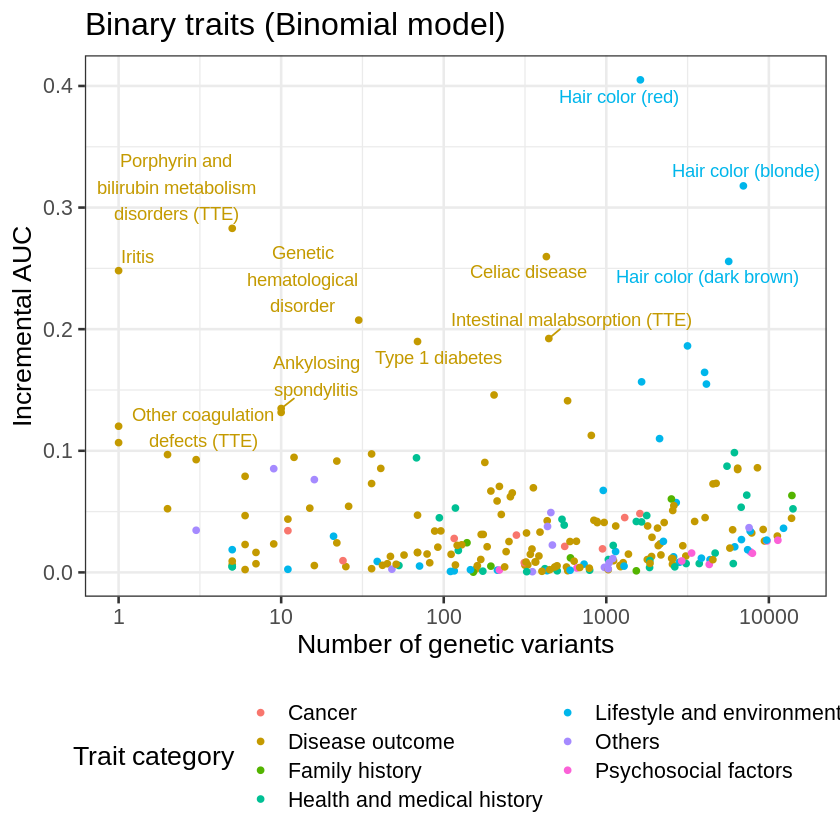

In [42]:
p_geno_delta_vs_size_binomial +
ggrepel::geom_text_repel(force=20, mapping = aes(label = plot_label))


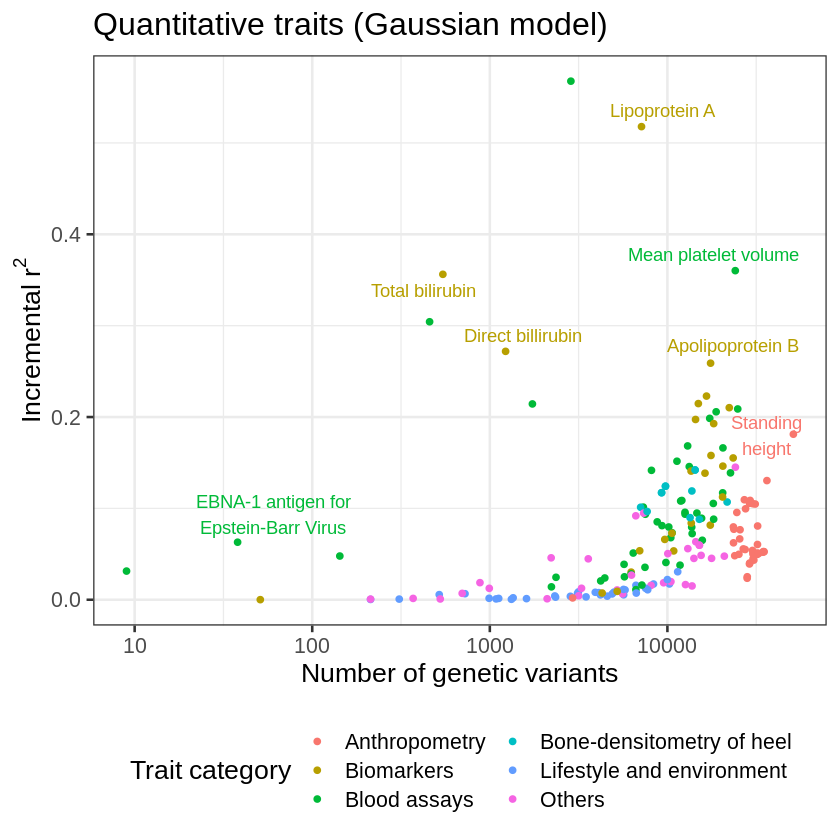

In [43]:
p_geno_delta_vs_size_gaussian +
ggrepel::geom_text_repel(force=20, mapping = aes(label = plot_label))

In [44]:
for(ext in c('png', 'pdf')){ggsave(
    sprintf('%s.%s', 'test_set_performance_vs_size', ext),
    gridExtra::arrangeGrob(
        # binomial
        p_geno_delta_vs_size_binomial +
        ggrepel::geom_text_repel(force=20, mapping = aes(label = plot_label)),
        # gaussian
        p_geno_delta_vs_size_gaussian +
        ggrepel::geom_text_repel(force=20, mapping = aes(label = plot_label)),
        # format
        ncol=2
    ),
    width=16, height=9
)}


In [49]:
for(ext in c('png', 'pdf')){ggsave(
    sprintf('%s.%s', 'test_set_performance_vs_size_binomial', ext),
    # binomial
    p_geno_delta_vs_size_binomial +
    ggrepel::geom_text_repel(force=20, mapping = aes(label = plot_label)),
    width=8, height=9
)}


In [50]:
for(ext in c('png', 'pdf')){ggsave(
    sprintf('%s.%s', 'test_set_performance_vs_size_gaussian', ext),
    # binomial
    p_geno_delta_vs_size_gaussian +
    ggrepel::geom_text_repel(force=20, mapping = aes(label = plot_label)),
    width=8, height=9
)}


### export them to plotly plots

- Those files are now hosted on AFS (/afs/ir.stanford.edu/users/y/t/ytanigaw/WWW/PRSmap)
  - http://web.stanford.edu/~ytanigaw/PRSmap/delta_vs_size_binomial.html
  - http://web.stanford.edu/~ytanigaw/PRSmap/delta_vs_size_gaussian.html


In [51]:
htmlwidgets::saveWidget(
    p_geno_delta_vs_size_binomial %>% plotly::ggplotly(),
    'ggplotly/delta_vs_size_binomial.html'
)

htmlwidgets::saveWidget(
    (p_geno_delta_vs_size_gaussian +
     # ggplotly does not support LaTex equation
    labs(y = 'Incremental r^2') )%>% plotly::ggplotly(),
    'ggplotly/delta_vs_size_gaussian.html'
)


### relationship between the two variables

In [52]:
glm(
    geno_delta ~ 0 + n_variables,
    data = summary_sig_df %>%
    filter(family == 'binomial')
) %>% 
summary()


Call:
glm(formula = geno_delta ~ 0 + n_variables, data = summary_sig_df %>% 
    filter(family == "binomial"))

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.06152  -0.00150   0.00939   0.03580   0.39256  

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
n_variables 7.688e-06  1.249e-06   6.157 3.07e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.004294607)

    Null deviance: 1.1978  on 242  degrees of freedom
Residual deviance: 1.0350  on 241  degrees of freedom
AIC: -629.23

Number of Fisher Scoring iterations: 2


In [53]:
cor_test_wrapper<-function(df, cor_test_method){cor.test(
    df %>% pull(geno_delta),
    df %>% pull(n_variables),
    method = cor_test_method
)}

In [54]:
summary_sig_df %>%
filter(family == 'binomial') %>%
cor_test_wrapper('spearman') 

Warning message in cor.test.default(df %>% pull(geno_delta), df %>% pull(n_variables), :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  df %>% pull(geno_delta) and df %>% pull(n_variables)
S = 2222200, p-value = 0.3591
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
0.05920362 


In [55]:
summary_sig_df %>%
filter(family == 'gaussian') %>%
cor_test_wrapper('spearman') 

Warning message in cor.test.default(df %>% pull(geno_delta), df %>% pull(n_variables), :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  df %>% pull(geno_delta) and df %>% pull(n_variables)
S = 491152, p-value = 1.353e-15
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.5420262 


## Trans-ethnic transferability

Violin plot for fraction performance in each population split relative to test split performance in WB
(so you’d have non-british white, s-asian, e-asian, african)

In [56]:
metric_col <- 'geno_delta'
trans_ethnic_eval_func <- function(ancestry_group_metric, WB_test_set_metric){
    ancestry_group_metric - WB_test_set_metric
}

eval_full_df %>%
select(all_of(c('trait', 'family', 'split', metric_col, 'is_significant_in_WB'))) %>%
inner_join(
    eval_full_df %>%
    eval_to_transethnic_eval_df(metric_col, trans_ethnic_eval_func),
    by=c('trait', 'split')
) %>%
left_join(get_split_order_df(), by='split') %>%
left_join(
    eval_full_df %>% filter(split == 'test') %>%
    select(all_of(c('trait', metric_col))) %>%
    rename(!!sprintf('%s_WBtest', metric_col) := all_of(metric_col)),
    by='trait'
) -> eval_trans_df


### how many traits do we have across ancestry groups?

For some traits (with low case N), we don't get the trans-ethnic evaluation

In [57]:
eval_trans_df %>% filter(is_significant_in_WB) %>%
count(family, split_plot, split_order) %>% spread(family, n) %>%
arrange(split_order) %>% select(-split_order)

split_plot,binomial,gaussian
<chr>,<int>,<int>
Non-British white,242,186
South Asian,241,186
East Asian,227,186
African,242,186


In [59]:
eval_trans_df %>%
filter(is_significant_in_WB, family=='binomial') %>%
plot_violin(metric_col) + labs(
    title = 'Binary traits (Binomial model)',
    y = latex2exp::TeX('The difference in incremental AUC compared against white British') 
) -> p_trans_violin_binomial


In [61]:
eval_trans_df %>%
filter(is_significant_in_WB, family=='gaussian') %>%
plot_violin(metric_col) + labs(
    title = 'Quantitative traits (Gaussian model)',
    y = latex2exp::TeX('The difference in incremental r^2 compared against white British') 
) -> p_trans_violin_gaussian


In [62]:
eval_trans_df %>%
filter(is_significant_in_WB, family=='binomial') %>%
plot_scatter() + labs(
    title = 'Binary traits (Binomial model)',
    x = latex2exp::TeX('Incremental AUC in white British'),
    y = latex2exp::TeX('Incremental AUC') 
) -> p_trans_scatter_binomial


$`Non-British white`
[1] 0.5863159

$`South Asian`
[1] 0.07657731

$`East Asian`
[1] -0.001134061

$African
[1] -0.07865199



In [63]:
eval_trans_df %>%
filter(is_significant_in_WB, family=='gaussian') %>%
plot_scatter() + labs(
    title = 'Quantitative traits (Gaussian model)',
    x = latex2exp::TeX('Incremental r^2 in white British'),
    y = latex2exp::TeX('Incremental r^2') 
) -> p_trans_scatter_gaussian


$`Non-British white`
[1] 0.9354429

$`South Asian`
[1] 0.5508495

$`East Asian`
[1] 0.3632301

$African
[1] 0.250069



In [64]:
for(ext in c('png', 'pdf')){ggsave(
    sprintf('%s.%s', 'trans-ethnic', ext),
    gridExtra::arrangeGrob(
        p_trans_violin_binomial,
        p_trans_violin_gaussian,
        p_trans_scatter_binomial,
        p_trans_scatter_gaussian,
        ncol=2
    ),
    width=16, height=16
)}
